In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import nltk
import mlflow
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

import re
import time
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel

import tensorflow_hub as hub

import pickle
import requests
import zipfile
import os

import mlflow


2024-11-20 15:36:10.636454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732116970.649995  975720 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732116970.653842  975720 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:36:10.667279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy
import tensorflow
import gensim
import numba
print("Numpy version:", numpy.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("Gensim version:", gensim.__version__)
print("Numba version:", numba.__version__)


Numpy version: 1.26.4
TensorFlow version: 2.18.0
Gensim version: 4.3.3
Numba version: 0.60.0


In [3]:
import os

# Définir un nouveau répertoire de suivi, par exemple, un dossier spécifique pour les expériences MLflow
tracking_dir = "/tmp/mlruns"  # Vous pouvez choisir un autre répertoire si nécessaire
os.makedirs(tracking_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas

#mlflow.set_tracking_uri(f"file://{tracking_dir}")
mlflow.set_tracking_uri("http://mlflow-server:5000")


In [4]:
# Recharger le DataFrame depuis le fichier pickle
df = pd.read_pickle('download/df_sample_20000.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  int64 
 1   ids     20000 non-null  int64 
 2   date    20000 non-null  object
 3   flag    20000 non-null  object
 4   user    20000 non-null  object
 5   text    20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [5]:
 #Vérifier si le DataFrame a au moins 16 000 lignes
if len(df) != 20000:
    raise ValueError("Le DataFrame ne contient pas de 20 000 lignes.")

# # Calculer la proportion nécessaire pour obtenir 16 000 lignes
# sample_size = 16000 / len(df_sample)

# # Utiliser train_test_split pour sélectionner un échantillon équilibré de 16 000 lignes
# df_16000, _ = train_test_split(df_sample, train_size=sample_size, stratify=df_sample['target'], random_state=42)

# # Vérifier le nombre d'éléments et l'équilibre des classes
# print(f"Nombre d'échantillons conservés: {len(df_16000)}")
# print(df_16000['target'].value_counts(normalize=True))  # Vérifier l'équilibre des classes
df_sample = df
display(df['target'].value_counts())


target
0    10000
1    10000
Name: count, dtype: int64

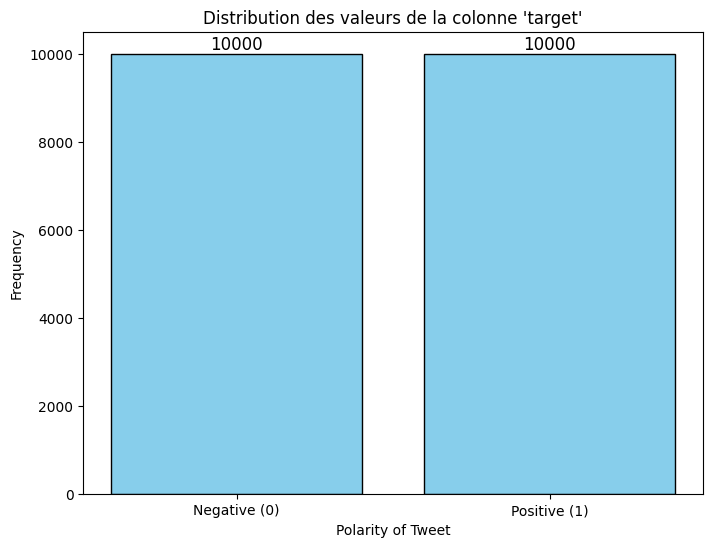

In [6]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 1
target_counts = df_sample['target'].value_counts().reindex([0, 1], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Positive (1)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
types_of_embeddings = ['w2v', 'fasttext', 'bert', 'use']

In [9]:
# Classe de prétraitement et vectorisation des tweets avec différentes méthodes
class TweetVectorizer:
    def __init__(self, vectorizer_type='w2v', method='lemmatize'):
        self.vectorizer_type = vectorizer_type
        self.method = method
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        
        # Initialiser le vectorizer en fonction du type
        if vectorizer_type == 'w2v':
            self.model = None  # Placeholder pour Word2Vec qui sera entraîné explicitement
        elif vectorizer_type == 'fasttext':
            self.fasttext_model = FastText(vector_size=100, window=5, min_count=1)
        elif vectorizer_type == 'bert':
            self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
            self.model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
        elif vectorizer_type == 'use':
            self.use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        else:
            raise ValueError("vectorizer_type doit être 'w2v', 'fasttext', 'bert', ou 'use'")
    
    def clean_tweet(self, tweet):
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)
        tweet = re.sub(r'@\w+', '', tweet)
        tweet = re.sub(r'#\w+', '', tweet)
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)
        tweet = re.sub(r'\s+', ' ', tweet)
        return tweet.strip()
        
    def preprocess(self, tweet):
        cleaned_tweet = self.clean_tweet(tweet)
        tokens = cleaned_tweet.split()
        
        # Appliquer le stemming ou la lemmatisation
        if self.method == 'stem':
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.method == 'lemmatize':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    
    # Méthode `fit_transform` mise à jour dans TweetVectorizer pour vérifier et ajuster la forme
    def fit_transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            self.fasttext_model.build_vocab(tokenized_docs)
            self.fasttext_model.train(tokenized_docs, total_examples=len(tokenized_docs), epochs=10)
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
        
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            # S'assurer que la deuxième dimension correspond bien à l'embedding dimension
            X = X.reshape(-1, X.shape[1])
        
        return X

    def transform(self, documents):
        documents_preprocessed = [self.preprocess(doc) for doc in documents]
        
        if self.vectorizer_type == 'w2v':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.model.wv[word] for word in words if word in self.model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'fasttext':
            tokenized_docs = [doc.split() for doc in documents_preprocessed]
            X = np.array([np.mean([self.fasttext_model.wv[word] for word in words if word in self.fasttext_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_docs])
        elif self.vectorizer_type == 'bert':
            X = self._bert_vectorize(documents_preprocessed)
        elif self.vectorizer_type == 'use':
            X = self.use_model(documents_preprocessed)
            X = np.array(X)
    
        # Assurer que X est bien en 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim == 2 and X.shape[1] == 1:
            X = X.reshape(-1, X.shape[1])
        
        return X

    def _bert_vectorize(self, documents):
        batch_size = 16  # Réduction de la taille du batch pour éviter les erreurs OOM
        batches = [documents[i:i + batch_size] for i in range(0, len(documents), batch_size)]
        
        outputs_list = []
        for batch in batches:
            tokenized_inputs = self.tokenizer(batch, return_tensors='tf', padding=True, truncation=True, max_length=32)
            outputs = self.model(tokenized_inputs).logits
            outputs_list.append(tf.reduce_mean(outputs, axis=1).numpy())
        
        return np.concatenate(outputs_list, axis=0)

In [10]:
from io import BytesIO

def log_plot_to_mlflow(figure, artifact_name):
    """
    Enregistre une figure matplotlib dans MLflow en utilisant un buffer en mémoire.

    :param figure: la figure matplotlib à sauvegarder
    :param artifact_name: le nom de l'artefact pour MLflow (inclure ".png")
    """
    # Utilisation d'un buffer en mémoire
    buffer = BytesIO()
    figure.savefig(buffer, format="png")
    buffer.seek(0)
    
    # Sauvegarder dans MLflow à partir du buffer
    with open(artifact_name, "wb") as f:
        f.write(buffer.getvalue())
    mlflow.log_artifact(artifact_name)

In [ ]:
# Classe pour la classification avec régression logistique
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
import mlflow
import mlflow.sklearn
import numpy as np
import time
import matplotlib.pyplot as plt

class TweetClassifier:
    def __init__(self, vectorizer_type='tfidf', method='lemmatize'):
        self.model = LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')
        self.vectorizer_type = vectorizer_type
        self.method = method

    def train_and_evaluate(self, X_train, X_val, y_train, y_val):
        # Suivi de l'entraînement du modèle dans MLflow comme sous-exécution
        with mlflow.start_run(run_name="Classification", nested=True):
            mlflow.set_tag("Stage", "Classification")
            mlflow.set_tag("model", "Logistic Regression")
            
            # Enregistrer les hyperparamètres du modèle
            mlflow.log_param("C", self.model.get_params()['C'])
            mlflow.log_param("solver", self.model.get_params()['solver'])
            mlflow.log_param("penalty", self.model.get_params()['penalty'])
            
            # Entraîner le modèle avec Cross-Validation sur le set d'entraînement
            cv_results = cross_validate(self.model, X_train, y_train, cv=5, 
                                                            scoring=['roc_auc', 'f1', 'accuracy', 'precision', 'recall'],
                                                            return_train_score=False)

            # Stockage des résultats de cross-validation
            metrics_dict = {
                "CrossVal ROC_AUC": round(cv_results['test_roc_auc'].mean(), 3),
                "CrossVal F1": round(cv_results['test_f1'].mean(), 3),
                "CrossVal Accuracy": round(cv_results['test_accuracy'].mean(), 3),
                "CrossVal Precision": round(cv_results['test_precision'].mean(), 3),
                "CrossVal Recall": round(cv_results['test_recall'].mean(), 3),
                "CrossVal Fit Time": round(cv_results['fit_time'].mean(), 3)
            }
            
            # Enregistrer les métriques de cross-validation dans MLflow
            mlflow.log_metrics(metrics_dict)
            
            # Entraîner sur l'ensemble d'entraînement complet
            start_time = time.time()
            self.model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time
            mlflow.log_metric("fit_time_seconds", training_time)
            
            # Évaluation sur l'ensemble de validation
            start_predict_time = time.time()
            y_val_pred = self.model.predict(X_val)
            end_predict_time = time.time()
            predict_time = end_predict_time - start_predict_time
            
            val_accuracy = accuracy_score(y_val, y_val_pred)
            mlflow.log_metric("validation_accuracy", val_accuracy)
            mlflow.log_text(classification_report(y_val, y_val_pred), "validation_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de validation
            y_val_prob = self.model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            roc_auc_val = auc(fpr, tpr)
            mlflow.log_metric("validation_roc_auc", roc_auc_val)

            # Tracer et enregistrer la courbe ROC
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_val.png")
            plt.close()
            
            # Tracer et enregistrer la courbe d'apprentissage
            train_sizes, train_scores, val_scores = learning_curve(
                self.model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
            )
            
            train_scores_mean = np.mean(train_scores, axis=1)
            val_scores_mean = np.mean(val_scores, axis=1)
            
            plt.figure()
            plt.plot(train_sizes, train_scores_mean, label="Training score")
            plt.plot(train_sizes, val_scores_mean, label="Validation score")
            plt.xlabel("Training Set Size")
            plt.ylabel("Accuracy")
            plt.title("Learning Curve")
            plt.legend(loc="best")
            plt.grid()
            # plt.savefig("images/modele-simple/learning_curve.png")
            # mlflow.log_artifact("images/modele-simple/learning_curve.png")
            log_plot_to_mlflow(plt.gcf(), "learning_curve.png")
            plt.close()
            
            # Calcul des métriques de validation uniquement
            validation_metrics = {    
                "Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
                "ROC_AUC": round(roc_auc_score(y_val, y_val_prob), 3),
                "F1": round(f1_score(y_val, y_val_pred), 3),
                "Precision": round(precision_score(y_val, y_val_pred), 3),
                "Recall": round(recall_score(y_val, y_val_pred), 3),
                "Predict Time": round(predict_time, 3)
            }
            
            mlflow.log_table(validation_metrics, "validation_metrics_table.json")
            # Sauvegarde du modèle pour reproductibilité
            mlflow.sklearn.log_model(self.model, "RegLog_"+self.vectorizer_type+"_"+self.method)
            # Enregistrer le modèle final}
            #mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            active_run = mlflow.active_run()
            run_id = mlflow.active_run().info.run_id
            result = mlflow.register_model(
                model_uri=f"runs:/{run_id}/model",
                name=f"RegLog_{self.vectorizer_type}_{self.method}"
            )
            
            # Récupérer l'ID de l'expérience active
            experiment_id = active_run.info.experiment_id

            # Définir l'URL de votre serveur MLflow
            mlflow_server_url = "http://localhost:5000"  # Remplacez par l'URL réel de votre serveur MLflow

            # Construire le lien complet vers le run dans l'interface MLflow
            run_link = f"{mlflow_server_url}/#/experiments/{experiment_id}/runs/{run_id}"
            
            
             # Exemple d'ajout d'un dictionnaire pour chaque configuration
            # Ajouter les métriques de validation à la liste
            all_validation_metrics.append({
                "vectorizer_type": self.vectorizer_type,
                "method": self.method,
                **validation_metrics,
                "run_link": run_link
            })
            
            print(f"Validation Accuracy : {val_accuracy}")
            print(classification_report(y_val, y_val_pred))
    
    def final_evaluation(self, X_test, y_test):
        # Évaluation finale sur le set de test
        with mlflow.start_run(run_name="Final Test Evaluation", nested=True):
            mlflow.set_tag("Stage", "Final Test Evaluation")
            y_test_pred = self.model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_text(classification_report(y_test, y_test_pred), "test_classification_report.txt")
            
            # Calcul de la courbe ROC-AUC sur l'ensemble de test
            y_test_prob = self.model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc_test = auc(fpr, tpr)
            mlflow.log_metric("test_roc_auc", roc_auc_test)
            
            metrics_dict = {
                "test_accuracy": test_accuracy,
                "test_roc_auc": roc_auc_test
            }
            
            mlflow.log_table(metrics_dict, "test_metrics_table.json")
            mlflow.set_tag("test_accuracy", test_accuracy)
            mlflow.set_tag("final_evaluation_metric", "test_roc_auc")

            # Tracer et enregistrer la courbe ROC pour le set de test
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Test Set")
            plt.legend(loc="lower right")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_test.png")
            plt.close()
            
            # Enregistrer le modèle final
            mlflow.sklearn.log_model(self.model, "logistic_regression_model")
            
            print(f"Test Accuracy : {test_accuracy}")
            print(classification_report(y_test, y_test_pred))


In [12]:
# Définition des combinaisons à tester
configurations = [
    {'vectorizer_type': 'w2v', 'method': 'lemmatize'},
    {'vectorizer_type': 'w2v', 'method': 'stem'},
    {'vectorizer_type': 'fasttext', 'method': 'lemmatize'},
    {'vectorizer_type': 'fasttext', 'method': 'stem'},
    {'vectorizer_type': 'bert', 'method': 'lemmatize'},
    {'vectorizer_type': 'bert', 'method': 'stem'},
    {'vectorizer_type': 'use', 'method': 'lemmatize'},
    {'vectorizer_type': 'use', 'method': 'stem'}
]

In [13]:
all_validation_metrics = []
experiment = mlflow.set_experiment("advanced-models")
# Séparer les données en Train, Validation et Test une seule fois
# Utiliser les tweets originaux pour diviser les ensembles de manière cohérente
y = df_sample['target']
tweets = df_sample['text']
y_train_val, y_test = train_test_split(y, test_size=0.2, random_state=42)
tweets_train_val, tweets_test = train_test_split(tweets, test_size=0.2, random_state=42)

# Rediviser l'ensemble Train + Validation en Train et Validation
y_train, y_val = train_test_split(y_train_val, test_size=0.25, random_state=42)
tweets_train, tweets_val = train_test_split(tweets_train_val, test_size=0.25, random_state=42)

# Boucle pour tester chaque configuration
for config in configurations:
    # Démarrer une nouvelle exécution parent pour chaque configuration
    with mlflow.start_run(run_name=f"{config['vectorizer_type']} + {config['method']}", nested=False):
        print(f"Testing configuration: {config}")
        
        # Enregistrer les paramètres de configuration comme tags
        mlflow.set_tag("vectorizer_type", config['vectorizer_type'])
        mlflow.set_tag("preprocessing_method", config['method'])
        
        # Initialiser et appliquer la vectorisation avec TweetVectorizer
        tweet_vectorizer = TweetVectorizer(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Vectorisation des ensembles Train, Validation et Test
        X_train = tweet_vectorizer.fit_transform(tweets_train)
        X_val = tweet_vectorizer.transform(tweets_val)
        X_test = tweet_vectorizer.transform(tweets_test)
        
        # Initialiser le classificateur
        classifier = TweetClassifier(vectorizer_type=config['vectorizer_type'], method=config['method'])
        
        # Entraîner et évaluer le modèle avec Train et Validation
        classifier.train_and_evaluate(X_train, X_val, y_train, y_val)

        # Évaluation finale sur le set de Test
        classifier.final_evaluation(X_test, y_test)
        
        # Convertir la liste en un dictionnaire (clé unique)
        data_to_log =  pd.DataFrame(all_validation_metrics)

        # Enregistrer dans MLflow comme un tableau
        mlflow.log_table(data=data_to_log, artifact_file="2-emb-validation.json")
        
        mlflow.end_run()

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'lemmatize'}


2024/11/20 15:36:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_w2v_lemmatize' already exists. Creating a new version of this model...
2024/11/20 15:36:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_w2v_lemmatize, version 3
Created version '3' of model 'RegLog_w2v_lemmatize'.
2024/11/20 15:36:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/dc3243daa6b64998ba2317baad292a94.
2024/11/20 15:36:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.61475
              precision    recall  f1-score   support

           0       0.62      0.59      0.60      1979
           1       0.61      0.64      0.63      2021

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



2024/11/20 15:36:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:36:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/b37755f08ff44f6aadc94b32b4156329.
2024/11/20 15:36:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:36:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/65808418823f487fb9c47b72a8ed5d91.
2024/11/20 15:36:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.6195
              precision    recall  f1-score   support

           0       0.63      0.60      0.62      2019
           1       0.61      0.64      0.62      1981

    accuracy                           0.62      4000
   macro avg       0.62      0.62      0.62      4000
weighted avg       0.62      0.62      0.62      4000

Testing configuration: {'vectorizer_type': 'w2v', 'method': 'stem'}


2024/11/20 15:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_w2v_stem' already exists. Creating a new version of this model...
2024/11/20 15:36:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_w2v_stem, version 3
Created version '3' of model 'RegLog_w2v_stem'.
2024/11/20 15:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/18b99926e9cf41babcf1e66fede541ee.
2024/11/20 15:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.627
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1979
           1       0.63      0.64      0.63      2021

    accuracy                           0.63      4000
   macro avg       0.63      0.63      0.63      4000
weighted avg       0.63      0.63      0.63      4000



2024/11/20 15:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/ff2ff4e88e1448f988c43ced9d2e76af.
2024/11/20 15:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run w2v + stem at: http://mlflow-server:5000/#/experiments/4/runs/484378380bca4fbcb129f999e6f79707.
2024/11/20 15:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.6235
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2019
           1       0.62      0.64      0.63      1981

    accuracy                           0.62      4000
   macro avg       0.62      0.62      0.62      4000
weighted avg       0.62      0.62      0.62      4000

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'lemmatize'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.64125
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1979
           1       0.64      0.65      0.65      2021

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



2024/11/20 15:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/81301c4465214b2b9d79132bebf22e20.
2024/11/20 15:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/6fdcb408e2594dc1b509545e939dd5c7.
2024/11/20 15:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.644
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2019
           1       0.64      0.65      0.64      1981

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

Testing configuration: {'vectorizer_type': 'fasttext', 'method': 'stem'}


/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Validation Accuracy : 0.65425
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1979
           1       0.66      0.66      0.66      2021

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000



2024/11/20 15:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/29682b9c67984668bdfc9cc6f8950900.
2024/11/20 15:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run fasttext + stem at: http://mlflow-server:5000/#/experiments/4/runs/e3c05c4505d940f982f79022a830e55f.
2024/11/20 15:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.65425
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      2019
           1       0.65      0.65      0.65      1981

    accuracy                           0.65      4000
   macro avg       0.65      0.65      0.65      4000
weighted avg       0.65      0.65      0.65      4000

Testing configuration: {'vectorizer_type': 'bert', 'method': 'lemmatize'}


2024-11-20 15:36:54.789168: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disab

Validation Accuracy : 0.55225
              precision    recall  f1-score   support

           0       0.55      0.54      0.55      1979
           1       0.56      0.56      0.56      2021

    accuracy                           0.55      4000
   macro avg       0.55      0.55      0.55      4000
weighted avg       0.55      0.55      0.55      4000



2024/11/20 15:47:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:47:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/06957d82958b4a7995dc17a70250ee6e.
2024/11/20 15:47:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:47:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/4d26245cdaf4447bad1fbc17454e6864.
2024/11/20 15:47:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.5555
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      2019
           1       0.55      0.56      0.56      1981

    accuracy                           0.56      4000
   macro avg       0.56      0.56      0.56      4000
weighted avg       0.56      0.56      0.56      4000

Testing configuration: {'vectorizer_type': 'bert', 'method': 'stem'}


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

Validation Accuracy : 0.507
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1979
           1       0.51      0.49      0.50      2021

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



2024/11/20 15:57:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:57:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/6155903d376c4a949a1af6eb32592cc2.
2024/11/20 15:57:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:57:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run bert + stem at: http://mlflow-server:5000/#/experiments/4/runs/d281de4385de4d339465dd42e5f3301e.
2024/11/20 15:57:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.5085
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2019
           1       0.50      0.49      0.50      1981

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000

Testing configuration: {'vectorizer_type': 'use', 'method': 'lemmatize'}


2024-11-20 15:57:18.121335: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 447969280 exceeds 10% of free system memory.
2024/11/20 15:57:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_use_lemmatize' already exists. Creating a new version of this model...
2024/11/20 15:57:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_use_lemmatize, version 3
Created version '3' of model 'RegLog_use_lemmatize'.
2024/11/20 15:57:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/146fbe58a68c4e0381f62c3e1b9a285b.
2024/11/20 15:57:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.773
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1979
           1       0.78      0.77      0.78      2021

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



2024/11/20 15:57:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:57:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/9d11eb92ac624f53952309004cd2bb8f.
2024/11/20 15:57:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:57:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + lemmatize at: http://mlflow-server:5000/#/experiments/4/runs/ba3ed80a12c146d49958fe2c30d6d1ab.
2024/11/20 15:57:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.7775
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2019
           1       0.77      0.78      0.78      1981

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000

Testing configuration: {'vectorizer_type': 'use', 'method': 'stem'}


2024-11-20 15:57:28.373554: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 447969280 exceeds 10% of free system memory.
2024/11/20 15:57:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RegLog_use_stem' already exists. Creating a new version of this model...
2024/11/20 15:57:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RegLog_use_stem, version 3
Created version '3' of model 'RegLog_use_stem'.
2024/11/20 15:57:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Classification at: http://mlflow-server:5000/#/experiments/4/runs/4f501dd0876f4607a228fe7fe85cc3d4.
2024/11/20 15:57:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Validation Accuracy : 0.76
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1979
           1       0.76      0.76      0.76      2021

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



2024/11/20 15:57:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/20 15:57:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Final Test Evaluation at: http://mlflow-server:5000/#/experiments/4/runs/f30a3870db4046b29ba1cb35ab98ac18.
2024/11/20 15:57:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.
2024/11/20 15:57:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run use + stem at: http://mlflow-server:5000/#/experiments/4/runs/89f51ad6e8a5483992bc17002fd0875b.
2024/11/20 15:57:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/4.


Test Accuracy : 0.754
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2019
           1       0.75      0.75      0.75      1981

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



In [14]:
display(pd.DataFrame(all_validation_metrics))

,vectorizer_type,method,Validation Accuracy,Validation ROC_AUC,Validation F1,Validation Precision,Validation Recall,Validation Predict Time,run_link
0,w2v,lemmatize,0.615,0.667,0.626,0.614,0.638,0.001,http://localhost:5000/#/experiments/4/runs/dc3...
1,w2v,stem,0.627,0.682,0.634,0.628,0.640,0.001,http://localhost:5000/#/experiments/4/runs/18b...
2,fasttext,lemmatize,0.641,0.698,0.645,0.645,0.646,0.000,http://localhost:5000/#/experiments/4/runs/f24...
3,fasttext,stem,0.654,0.706,0.658,0.658,0.659,0.001,http://localhost:5000/#/experiments/4/runs/bd3...
4,bert,lemmatize,0.552,0.580,0.559,0.556,0.562,0.000,http://localhost:5000/#/experiments/4/runs/4a7...
5,bert,stem,0.507,0.509,0.504,0.513,0.495,0.000,http://localhost:5000/#/experiments/4/runs/62b...
6,use,lemmatize,0.773,0.859,0.775,0.776,0.774,0.004,http://localhost:5000/#/experiments/4/runs/146...
7,use,stem,0.760,0.837,0.762,0.762,0.762,0.003,http://localhost:5000/#/experiments/4/runs/4f5...


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional  # Ajout de Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText

In [ ]:

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

class LSTMTweetClassifier:
    def __init__(self, embedding_type='w2v', embedding_dim=100, lstm_units=128, max_length=100):
        self.embedding_type = embedding_type
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_length = max_length
        self.tokenizer = Tokenizer()
        self.model = None
        self.stop_words = set(stopwords.words('english'))

    def clean_tweet(self, tweet):
        """Nettoie le texte du tweet en supprimant les liens, mentions, hashtags et caractères spéciaux."""
        tweet = tweet.lower()
        tweet = re.sub(r'www\S+|http\S+', '', tweet)  # Supprime les liens
        tweet = re.sub(r'@\w+', '', tweet)            # Supprime les mentions
        tweet = re.sub(r'#\w+', '', tweet)            # Supprime les hashtags
        tweet = re.sub(r'[^A-Za-z ]+', ' ', tweet)    # Supprime les caractères spéciaux
        tweet = re.sub(r'\s+', ' ', tweet)            # Remplace les multiples espaces par un seul espace
        return tweet.strip()

    def preprocess_and_tokenize(self, documents):
        # Nettoyage et suppression des stopwords
        cleaned_docs = []
        for doc in documents:
            cleaned_doc = self.clean_tweet(doc)
            words = cleaned_doc.split()
            filtered_words = [word for word in words if word not in self.stop_words]
            cleaned_docs.append(' '.join(filtered_words))
        
        # Convertir les documents nettoyés en tokens
        self.tokenizer.fit_on_texts(cleaned_docs)
        sequences = self.tokenizer.texts_to_sequences(cleaned_docs)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post')
        return padded_sequences

    def build_embedding_matrix(self, documents):
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))
        
        # Préparation des phrases pour l'entraînement d'embeddings
        sentences = [self.clean_tweet(doc).split() for doc in documents]
        
        if self.embedding_type == 'w2v':
            model = Word2Vec(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        elif self.embedding_type == 'fasttext':
            model = FastText(sentences=sentences, vector_size=self.embedding_dim, window=5, min_count=1, workers=4)
        else:
            raise ValueError("embedding_type must be 'w2v' or 'fasttext'")
        
        for word, i in word_index.items():
            if word in model.wv:
                embedding_matrix[i] = model.wv[word]
        
        return embedding_matrix

    # def build_model(self, vocab_size, embedding_matrix):
    #     """Construit le modèle LSTM avec les paramètres spécifiés."""
    #     self.model = Sequential()
    #     self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, 
    #                              weights=[embedding_matrix], input_length=self.max_length, trainable=False))
    #     self.model.add(Bidirectional(LSTM(self.lstm_units, return_sequences=False)))
    #     self.model.add(Dense(1, activation='sigmoid'))
    #     self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    def build_model(self, vocab_size, embedding_matrix):
        """
        Fonction pour construire un modèle LSTM bidirectionnel pour une tâche de classification binaire.
        Arguments :
            vocab_size (int) : Taille du vocabulaire, c'est-à-dire le nombre de mots uniques dans les données.
            embedding_matrix (numpy.array) : Matrice d'embedding pré-entraînée contenant les vecteurs des mots.
        Retourne :
            model (Sequential) : Modèle LSTM construit.
        """

        # Initialisation d'un modèle séquentiel où les couches sont empilées linéairement
        self.model = Sequential()

        # Ajout d'une couche d'embedding pour transformer les tokens en vecteurs denses
        # input_dim : Nombre total de mots dans le vocabulaire (vocab_size).
        # output_dim : Dimension des vecteurs d'embedding (ici, 100).
        # weights : Utilisation de la matrice pré-entraînée `embedding_matrix`.
        # input_length : Longueur maximale des séquences d'entrée.
        # trainable=False : Les poids de l'embedding sont figés et non entraînés.
        self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, 
                            weights=[embedding_matrix], input_length=self.max_length, trainable=False))

        # Ajout d'une première couche LSTM bidirectionnelle
        # 256 : Nombre d'unités LSTM dans chaque direction (forward et backward).
        # return_sequences=True : Indique que cette couche retourne une séquence complète (pas uniquement la dernière sortie).
        # dropout : Taux de dropout sur les connexions de la couche LSTM pour éviter l'overfitting.
        # recurrent_dropout : Taux de dropout sur les connexions récurrentes (mémoire de l'état).
        self.model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))

        # Ajout d'une seconde couche LSTM bidirectionnelle
        # 128 : Moins d'unités que la précédente couche pour capturer des relations plus générales.
        # return_sequences=False : Retourne uniquement la dernière sortie (pas la séquence complète).
        self.model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))

        # Ajout d'une couche Dense entièrement connectée
        # 64 : Nombre de neurones dans la couche dense pour capturer des caractéristiques abstraites.
        # activation='relu' : Fonction d'activation ReLU pour introduire la non-linéarité.
        # kernel_regularizer : Ajout de régularisation L2 pour réduire l'overfitting.
        self.model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

        # Ajout de la couche de sortie
        # 1 : Une seule unité pour une tâche de classification binaire.
        # activation='sigmoid' : Fonction d'activation sigmoid pour produire une probabilité entre 0 et 1.
        self.model.add(Dense(1, activation='sigmoid'))

        # Compilation du modèle
        # optimizer='adam' : Algorithme Adam pour l'optimisation avec un taux d'apprentissage ajustable.
        # loss='binary_crossentropy' : Fonction de perte pour une tâche de classification binaire.
        # metrics=['accuracy', 'AUC'] : Mesures pour suivre la précision et l'AUC pendant l'entraînement.
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

        return self.model  # Retourne le modèle final prêt à être entraîné.


    def track_metrics(self, y_true, y_pred, prefix=""):
        """Enregistre les métriques de classification dans MLflow."""
        accuracy = np.mean((y_pred > 0.5).flatten() == y_true)
        auc = roc_auc_score(y_true, y_pred)
        mlflow.log_metric(f"{prefix}_accuracy", accuracy)
        mlflow.log_metric(f"{prefix}_auc", auc)
        return accuracy, auc

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        """Entraîne le modèle et enregistre les métriques et modèles dans MLflow."""
        if self.model is None:
            raise RuntimeError("Model has not been built. Call build_model() before training.")
        
        with mlflow.start_run(run_name=f"LSTM + {config['embedding_type']}-{config['epochs']}", nested=True):
            # Log des hyperparamètres spécifiques à cette configuration
            mlflow.log_param("embedding_type", self.embedding_type)
            mlflow.log_param("embedding_dim", self.embedding_dim)
            mlflow.log_param("lstm_units", self.lstm_units)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)

            start_time = time.time()
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs, batch_size=batch_size
            )
            train_duration = time.time() - start_time
            mlflow.log_metric("train_duration", train_duration)

            # Log des métriques d'entraînement et de validation
            for epoch in range(epochs):
                mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
        
            # Évaluation sur l'ensemble de validation
            start_predict_time = time.time()
            y_val_pred = self.model.predict(X_val).flatten()
            predict_time = time.time() - start_predict_time
            #self.track_metrics(y_val, y_val_pred, prefix="val")
            
            # Calcul des métriques de validation
            validation_metrics = {    
                "Accuracy": round(accuracy_score(y_val, (y_val_pred > 0.5).astype(int)), 3),
                "ROC_AUC": round(roc_auc_score(y_val, y_val_pred), 3),
                "F1": round(f1_score(y_val, (y_val_pred > 0.5).astype(int)), 3),
                "Precision": round(precision_score(y_val, (y_val_pred > 0.5).astype(int)), 3),
                "Recall": round(recall_score(y_val, (y_val_pred > 0.5).astype(int)), 3),
                "Predict Time": round(predict_time, 3)
            }
            mlflow.log_table(validation_metrics, "validation_metrics_table.json")
            # Enregistrer les métriques de validation dans MLflow
            mlflow.log_metrics(validation_metrics)
            
            # Log des métriques dans MLflow
            for key, value in validation_metrics.items():
             mlflow.log_metric(key, value)
             
            
            # Calcul des probabilités pour ROC AUC
            #y_val_prob = self.model.predict_proba(X_val)[:, 1]
            y_val_prob = self.model.predict(X_val).flatten()
            
            # Tracer et enregistrer la courbe ROC
            fpr, tpr, _ = roc_curve(y_val, y_val_prob)
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC curve (area = {validation_metrics['ROC_AUC']:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve - Validation Set")
            plt.legend(loc="lower right")
            # plt.savefig("images/modele-simple/roc_curve_val.png")
            # mlflow.log_artifact("roc_curve_val.png")
            log_plot_to_mlflow(plt.gcf(), "roc_curve_val.png")
            plt.close()
            

            # Log du modèle
            mlflow.keras.log_model(self.model, "LSTM"+self.embedding_type+"_"+str(self.embedding_dim)+"_"+str(self.lstm_units))
            run_id = mlflow.active_run().info.run_id
            result = mlflow.register_model(
                model_uri=f"runs:/{run_id}/model",
                name=f"LSTM_{self.embedding_type}_{self.embedding_dim}_{self.lstm_units}"
            )
            # Construire le lien MLflow correspondant (en supposant que vous avez l'URL de votre serveur MLflow)
            active_run = mlflow.active_run()
            run_id = active_run.info.run_id
            #run_name = active_run.data.tags.get("mlflow.runName")  # Obtenir le nom du run depuis les tags

            # Récupérer l'ID de l'expérience active
            experiment_id = active_run.info.experiment_id

            # Définir l'URL de votre serveur MLflow
            mlflow_server_url = "http://localhost:5000"  # Remplacez par l'URL réel de votre serveur MLflow

            # Construire le lien complet vers le run dans l'interface MLflow
            run_link = f"{mlflow_server_url}/#/experiments/{experiment_id}/runs/{run_id}"
            

             # Exemple d'ajout d'un dictionnaire pour chaque configuration
            # Ajouter les métriques de validation à la liste
            all_validation_metrics.append({
                "run_name": f"{self.embedding_type}_{self.embedding_dim}",
                **validation_metrics,
                "run_link": run_link
            })

    def fit(self, documents, labels, test_size=0.2, val_split=0.2, epochs=10, batch_size=32):
        # Nettoyage, tokenisation et padding des données
        padded_sequences = self.preprocess_and_tokenize(documents)
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = self.build_embedding_matrix(documents)

        # Construire le modèle
        self.build_model(vocab_size, embedding_matrix)

        # Découper les données en train/test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            padded_sequences, labels, test_size=test_size, random_state=42
        )

        # Découper l'ensemble train en train/validation
        val_split_index = int(len(X_train_val) * (1 - val_split))
        X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
        y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

        print(f"Training data: {len(X_train)} samples")
        print(f"Validation data: {len(X_val)} samples")
        print(f"Test data: {len(X_test)} samples")

        # Entraîner et évaluer
        self.train_and_evaluate(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

        # Évaluation finale sur l'ensemble de test
        print("\nFinal Evaluation on Test Set:")
        y_test_pred = self.model.predict(X_test).flatten()
        test_metrics = {    
            "Test Accuracy": round(accuracy_score(y_test, (y_test_pred > 0.5).astype(int)), 3),
            "Test ROC_AUC": round(roc_auc_score(y_test, y_test_pred), 3),
            "Test F1": round(f1_score(y_test, (y_test_pred > 0.5).astype(int)), 3),
            "Test Precision": round(precision_score(y_test, (y_test_pred > 0.5).astype(int)), 3),
            "Test Recall": round(recall_score(y_test, (y_test_pred > 0.5).astype(int)), 3),
        }
        
        print(test_metrics)
        for key, value in test_metrics.items():
            mlflow.log_metric(f"test_{key.lower()}", value)
            
    def predict(self, documents):
        padded_sequences = self.preprocess_and_tokenize(documents)
        predictions = self.model.predict(padded_sequences)
        return (predictions > 0.5).astype(int).flatten()

In [23]:
configurations = [
    {
        "embedding_type": "w2v",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
    {
        "embedding_type": "fasttext",
        "embedding_dim": 100,
        "lstm_units": 128,
        "epochs": 10,
        "batch_size": 32
    },
]


In [24]:
experiment = mlflow.set_experiment("LSTM")
documents = df_sample['text']
labels = df_sample['target']
all_validation_metrics = []

# Boucle sur chaque configuration pour tester
for config in configurations:
    with mlflow.start_run(run_name=f"LSTM {config['embedding_type']} + {config['embedding_dim']}", nested=False):
    
        print(f"\n Testing configuration: {config} \n")
        # with mlflow.start_run(run_name=f"LSTM + {config['embedding_type']}-{config['epochs']}", nested=False):
        #     mlflow.set_tag("Model_Type", "LSTM")
        #     mlflow.set_tag("embedding_type", config["embedding_type"])
        #     mlflow.set_tag("epochs", config["epochs"])
        #     mlflow.log_params(config)
        
        model = LSTMTweetClassifier(
            embedding_type=config["embedding_type"],
            embedding_dim=config["embedding_dim"],
            max_length=100  # Vous pouvez ajuster cette valeur si nécessaire
        )
        # Entraînement du modèle avec la configuration actuelle
        model.fit(
            documents, 
            labels, 
            epochs=config["epochs"], 
            batch_size=config["batch_size"]
        )
        
        
        # Convertir la liste en un dictionnaire (clé unique)
        data_to_log =  pd.DataFrame(all_validation_metrics)

        # Enregistrer dans MLflow comme un tableau
        mlflow.log_table(data=data_to_log, artifact_file="2-LSTM-validation.json")
     
        mlflow.end_run()
        # Ici, vous pouvez ajouter des étapes pour enregistrer ou comparer les résultats, par exemple :
        # - Enregistrer les métriques dans un dictionnaire ou un fichier pour une analyse ultérieure
        # - Comparer les résultats dans MLFlow
        print(f"Finished testing configuration: {config}\n")


 Testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32} 

Training data: 12800 samples
Validation data: 3200 samples
Test data: 4000 samples
Epoch 1/10


/opt/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 121s 291ms/step - AUC: 0.5382 - accuracy: 0.5243 - loss: 1.5380 - val_AUC: 0.6012 - val_accuracy: 0.5584 - val_loss: 1.1177
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 285ms/step - AUC: 0.5802 - accuracy: 0.5534 - loss: 1.0401 - val_AUC: 0.6029 - val_accuracy: 0.5703 - val_loss: 0.8539
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 113s 283ms/step - AUC: 0.5955 - accuracy: 0.5691 - loss: 0.8217 - val_AUC: 0.6054 - val_accuracy: 0.5703 - val_loss: 0.7425
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 284ms/step - AUC: 0.6161 - accuracy: 0.5844 - loss: 0.7272 - val_AUC: 0.6176 - val_accuracy: 0.5772 - val_loss: 0.7003
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 284ms/step - AUC: 0.6150 - accuracy: 0.5821 - loss: 0.6945 - val_AUC: 0.6272 - val_accuracy: 0.5759 - val_loss: 0.6833
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 114s 284ms/step - AUC: 0.6114 - accuracy: 0.5778 - loss: 0.6833 - val_AUC: 0.6142 - val_accuracy: 0.5675 - val_loss: 0.6834
Epoch 7/10
400/400 ━━━━━━━━

2024/11/20 19:57:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/20 19:57:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LSTM_w2v_100_128' already exists. Creating a new version of this model...
2024/11/20 19:57:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_w2v_100_128, version 5
Created version '5' of model 'LSTM_w2v_100_128'.
2024/11/20 19:57:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM + w2v-10 at: http://mlflow-server:5000/#/experiments/5/runs/114037bb7de84fe8a85c13e2949083a9.
2024/11/20 19:57:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/5.



Final Evaluation on Test Set:
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step
{'Test Accuracy': 0.605, 'Test ROC_AUC': 0.644, 'Test F1': 0.606, 'Test Precision': 0.598, 'Test Recall': 0.614}


2024/11/20 19:57:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM w2v + 100 at: http://mlflow-server:5000/#/experiments/5/runs/c783b8680505448d899341f88cc624f6.
2024/11/20 19:57:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/5.


Finished testing configuration: {'embedding_type': 'w2v', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}


 Testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32} 

Training data: 12800 samples
Validation data: 3200 samples
Test data: 4000 samples
Epoch 1/10


/opt/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 123s 298ms/step - AUC: 0.5149 - accuracy: 0.5148 - loss: 1.5474 - val_AUC: 0.5836 - val_accuracy: 0.5512 - val_loss: 1.1420
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 127s 317ms/step - AUC: 0.5694 - accuracy: 0.5477 - loss: 1.0626 - val_AUC: 0.5905 - val_accuracy: 0.5634 - val_loss: 0.8753
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 123s 307ms/step - AUC: 0.5829 - accuracy: 0.5562 - loss: 0.8428 - val_AUC: 0.5891 - val_accuracy: 0.5606 - val_loss: 0.7618
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 118s 295ms/step - AUC: 0.5977 - accuracy: 0.5758 - loss: 0.7456 - val_AUC: 0.5825 - val_accuracy: 0.5437 - val_loss: 0.7214
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 117s 292ms/step - AUC: 0.5865 - accuracy: 0.5678 - loss: 0.7109 - val_AUC: 0.5911 - val_accuracy: 0.5572 - val_loss: 0.6996
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 142s 293ms/step - AUC: 0.5972 - accuracy: 0.5709 - loss: 0.6933 - val_AUC: 0.5866 - val_accuracy: 0.5356 - val_loss: 0.7043
Epoch 7/10
400/400 ━━━━━━━━

2024/11/20 20:18:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/20 20:18:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LSTM_fasttext_100_128' already exists. Creating a new version of this model...
2024/11/20 20:18:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM_fasttext_100_128, version 5
Created version '5' of model 'LSTM_fasttext_100_128'.
2024/11/20 20:18:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM + fasttext-10 at: http://mlflow-server:5000/#/experiments/5/runs/29f72c23b1174df694790ec1458c008d.
2024/11/20 20:18:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/5.



Final Evaluation on Test Set:
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step
{'Test Accuracy': 0.571, 'Test ROC_AUC': 0.604, 'Test F1': 0.592, 'Test Precision': 0.56, 'Test Recall': 0.629}


2024/11/20 20:18:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM fasttext + 100 at: http://mlflow-server:5000/#/experiments/5/runs/a5ed0b9d11af4eeebf269ace5d27562f.
2024/11/20 20:18:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/5.


Finished testing configuration: {'embedding_type': 'fasttext', 'embedding_dim': 100, 'lstm_units': 128, 'epochs': 10, 'batch_size': 32}



In [25]:
display(pd.DataFrame(all_validation_metrics))

,vectorizer_type,method,Accuracy,ROC_AUC,F1,Precision,Recall,Predict Time,run_link
0,w2v,100,0.600,0.643,0.613,0.606,0.620,8.395,http://localhost:5000/#/experiments/5/runs/114...
1,fasttext,100,0.567,0.604,0.593,0.570,0.617,7.443,http://localhost:5000/#/experiments/5/runs/29f...


In [26]:
df_sample['target'].value_counts()

target
0    10000
1    10000
Name: count, dtype: int64

In [27]:
import re
import emoji
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Prétraitement des tweets
def tokenize_hashtags(text):
    """
    Tokenise les hashtags en séparant les mots (ex. #HappyBirthday -> happy birthday).
    """
    return re.sub(r'#(\w+)', lambda m: ' '.join(re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', m.group(1))), text)

def remove_urls(text):
    """Supprime les URLs du texte."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text):
    """Supprime les mentions (@user) du texte."""
    return re.sub(r'@\w+', '', text)

def remove_emojis(text):
    """Supprime les emojis du texte."""
    return emoji.demojize(text)

def to_lowercase(text):
    """Convertit le texte en minuscules."""
    return text.lower()

def remove_special_characters(text):
    """Supprime les caractères spéciaux du texte."""
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_extra_whitespace(text):
    """Supprime les espaces en trop."""
    return re.sub(r'\s+', ' ', text).strip()

def preprocess_tweet(tweet):
    """
    Nettoie et prétraite un tweet.
    - Conserve les hashtags mais les tokenise en mots.
    - Supprime les URLs, mentions, emojis et caractères spéciaux.
    """
    tweet = remove_urls(tweet)
    tweet = remove_mentions(tweet)
    tweet = tokenize_hashtags(tweet)
    tweet = remove_emojis(tweet)
    tweet = to_lowercase(tweet)
    tweet = remove_special_characters(tweet)
    tweet = remove_extra_whitespace(tweet)
    return tweet

# Nettoyer les tweets
df_sample['cleaned_text'] = df_sample['text'].apply(preprocess_tweet)


In [29]:
# Liste pour stocker les métriques de validation pour comparaison
mlflow.set_experiment("pretrained-models")

<Experiment: artifact_location='/tmp/mlruns/7', creation_time=1731940223943, experiment_id='7', last_update_time=1731940223943, lifecycle_stage='active', name='pretrained-models', tags={}>

In [33]:

# 2. Fonction de remapping des prédictions
def map_predictions(predictions):
    """
    Remap classe 2 (neutre) à 1 (positif) pour une classification binaire.
    """
    return [0 if pred == 0 else 1 for pred in predictions]

# 3. Fonction pour évaluer un modèle
# Fonction pour évaluer un modèle avec analyse des erreurs
def evaluate_model(model_name, documents, labels, max_length=128, test_size=0.2):
    """
    Évalue un modèle pré-entraîné sur un ensemble de validation et collecte les métriques.
    Ajoute une analyse des faux positifs et faux négatifs.
    """
    # Charger la configuration, tokenizer et modèle
    config = AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    try:
        # Charger le modèle TensorFlow
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    except OSError:
        # Charger le modèle PyTorch si TensorFlow n'est pas disponible
        print(f"Model {model_name} is in PyTorch format, converting to TensorFlow using `from_pt=True`.")
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config, from_pt=True)

    # Diviser les données en ensemble d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(documents, labels, test_size=test_size, random_state=42)

    # Tokenisation des données
    def tokenize_texts(texts):
        encoding = tokenizer(
            texts.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="np"
        )
        return encoding["input_ids"], encoding["attention_mask"]

    input_ids_val, attention_masks_val = tokenize_texts(X_val)

    with mlflow.start_run(run_name=f"Evaluation {model_name}", nested=True):
        mlflow.set_tag("model", model_name)

        # Prédictions sur l'ensemble de validation
        start_predict_time = time.time()
        outputs = model.predict([input_ids_val, attention_masks_val])
        predict_time = time.time() - start_predict_time

        logits = outputs.logits
        y_val_prob = tf.nn.softmax(logits, axis=-1).numpy()[:, 1]
        y_val_pred = np.argmax(logits, axis=-1)

        # Remap des prédictions si le modèle utilise 3 classes
        if config.num_labels == 3:
            print(f"Remapping predictions for binary classification (Model: {model_name})...")
            y_val_pred = map_predictions(y_val_pred)

                # Calcul des métriques de validation
        validation_metrics = {
            "Accuracy": round(accuracy_score(y_val, y_val_pred), 3),
            "ROC_AUC": round(roc_auc_score(y_val, y_val_prob, multi_class='ovr'), 3),
            "F1": round(f1_score(y_val, y_val_pred, average="weighted"), 3),
            "Precision": round(precision_score(y_val, y_val_pred, average="weighted"), 3),
            "Recall": round(recall_score(y_val, y_val_pred, average="weighted"), 3),
            "Predict Time": round(predict_time, 3)
        }

        # Enregistrer les métriques dans MLflow
        mlflow.log_metrics(validation_metrics)

        # Analyse des erreurs (faux positifs et faux négatifs)
        false_positives = pd.DataFrame({"text": X_val[(y_val == 0) & (y_val_pred == 1)]})
        false_negatives = pd.DataFrame({"text": X_val[(y_val == 1) & (y_val_pred == 0)]})

        # Calculer les taux
        fp_rate = len(false_positives) / sum(y_val == 0)
        fn_rate = len(false_negatives) / sum(y_val == 1)

        # Ajouter les longueurs des textes pour l'analyse
        false_positives["text_length"] = false_positives["text"].apply(len)
        false_negatives["text_length"] = false_negatives["text"].apply(len)

        # Log des taux dans MLflow
        mlflow.log_metric("False Positive Rate", fp_rate * 100)
        mlflow.log_metric("False Negative Rate", fn_rate * 100)

        # Graphique de distribution des longueurs pour les erreurs
        plt.figure(figsize=(8, 6))
        plt.hist(false_positives["text_length"], bins=20, alpha=0.5, label="Faux Positifs")
        plt.hist(false_negatives["text_length"], bins=20, alpha=0.5, label="Faux Négatifs")
        plt.legend()
        plt.title(f"Distribution des longueurs de tweets pour les erreurs - {model_name}")
        plt.xlabel("Longueur du tweet")
        plt.ylabel("Fréquence")

        # Sauvegarder et enregistrer dans MLflow
        #plt.savefig(f"errors_text_length_distribution_{model_name}.png")
        #mlflow.log_artifact(f"errors_text_length_distribution_{model_name}.png")
        mlflow.log_figure(plt.gcf(), f"errors_text_length_distribution_{model_name}.png")
        plt.close()

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        roc_auc_val = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        mlflow.log_figure(plt.gcf(), f"roc_curve_{model_name}.png")
        plt.close()

        active_run = mlflow.active_run()
        run_id = active_run.info.run_id
        
        
        result = mlflow.register_model(
            model_uri=f"runs:/{run_id}/model",
            name=f"{model_name}"
        )
        
         # Récupérer l'ID de l'expérience active
        experiment_id = active_run.info.experiment_id

        # Définir l'URL de votre serveur MLflow
        mlflow_server_url = "http://localhost:5000"  # Remplacez par l'URL réel de votre serveur MLflow

        # Construire le lien complet vers le run dans l'interface MLflow
        run_link = f"{mlflow_server_url}/#/experiments/{experiment_id}/runs/{run_id}"
        
        # Ajout des métriques pour la comparaison
        all_validation_metrics.append({
            "model_name": model_name,
            **validation_metrics,
            "run_link": run_link
            # "False Positive Rate": round(fp_rate * 100, 3),
            # "False Negative Rate": round(fn_rate * 100, 3),
        })

        # Affichage des résultats
        print(f"Model: {model_name}")
        print(validation_metrics)
        print(f"False Positive Rate: {fp_rate * 100:.2f}%")
        print(f"False Negative Rate: {fn_rate * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_val, y_val_pred))
        print("-" * 50)




In [36]:
df_sample['target'].value_counts()

target
0    10000
1    10000
Name: count, dtype: int64

In [37]:
# Données : textes et labels nettoyés
documents = df_sample['cleaned_text']
labels = df_sample['target']
all_validation_metrics = []
# 4. Évaluation des modèles
with mlflow.start_run(run_name="Pre-Trained", nested=False):

    evaluate_model('bert-base-uncased', documents, labels, max_length=80)
    evaluate_model('textattack/bert-base-uncased-imdb', documents, labels, max_length=80)  # Modèle fine-tuné pour sentiments
    evaluate_model('cardiffnlp/twitter-roberta-base-sentiment', documents, labels, max_length=80)
    evaluate_model('finiteautomata/bertweet-base-sentiment-analysis', documents, labels, max_length=80)  # Modèle fine-tuné pour tweets
    evaluate_model('vinai/bertweet-base', documents, labels, max_length=80)
    evaluate_model('nlptown/bert-base-multilingual-uncased-sentiment', documents, labels, max_length=80)
    evaluate_model('distilbert-base-uncased', documents, labels, max_length=80)
    
    # Convertir la liste en un dictionnaire (clé unique)
    data_to_log =  pd.DataFrame(all_validation_metrics)

    # Enregistrer dans MLflow comme un tableau
    mlflow.log_table(data=data_to_log, artifact_file="2-pre-trained.json")

    mlflow.end_run()
    

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


125/125 [==============================] - 182s 1s/step


Registered model 'bert-base-uncased' already exists. Creating a new version of this model...
2024/11/21 08:25:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: bert-base-uncased, version 4
Created version '4' of model 'bert-base-uncased'.
2024/11/21 08:25:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation bert-base-uncased at: http://mlflow-server:5000/#/experiments/7/runs/0b124af4f4da425f93e4a28068963289.
2024/11/21 08:25:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: bert-base-uncased
{'Accuracy': 0.5, 'ROC_AUC': 0.508, 'F1': 0.496, 'Precision': 0.501, 'Recall': 0.5, 'Predict Time': 182.507}
False Positive Rate: 58.64%
False Negative Rate: 41.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      2019
           1       0.50      0.59      0.54      1981

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000

--------------------------------------------------
Model textattack/bert-base-uncased-imdb is in PyTorch format, converting to TensorFlow using `from_pt=True`.


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


125/125 [==============================] - 171s 1s/step


Successfully registered model 'textattack/bert-base-uncased-imdb'.
2024/11/21 08:28:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: textattack/bert-base-uncased-imdb, version 1
Created version '1' of model 'textattack/bert-base-uncased-imdb'.
2024/11/21 08:28:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation textattack/bert-base-uncased-imdb at: http://mlflow-server:5000/#/experiments/7/runs/e9f28ab90a514156af38b0f164bf6d89.
2024/11/21 08:28:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: textattack/bert-base-uncased-imdb
{'Accuracy': 0.643, 'ROC_AUC': 0.69, 'F1': 0.642, 'Precision': 0.644, 'Recall': 0.643, 'Predict Time': 170.754}
False Positive Rate: 39.87%
False Negative Rate: 31.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      2019
           1       0.63      0.69      0.66      1981

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000

--------------------------------------------------


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


125/125 [==============================] - 169s 1s/step
Remapping predictions for binary classification (Model: cardiffnlp/twitter-roberta-base-sentiment)...


Successfully registered model 'cardiffnlp/twitter-roberta-base-sentiment'.
2024/11/21 08:31:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: cardiffnlp/twitter-roberta-base-sentiment, version 1
Created version '1' of model 'cardiffnlp/twitter-roberta-base-sentiment'.
2024/11/21 08:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation cardiffnlp/twitter-roberta-base-sentiment at: http://mlflow-server:5000/#/experiments/7/runs/9ae02d8113884043973825d60ae532bb.
2024/11/21 08:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: cardiffnlp/twitter-roberta-base-sentiment
{'Accuracy': 0.718, 'ROC_AUC': 0.499, 'F1': 0.707, 'Precision': 0.756, 'Recall': 0.718, 'Predict Time': 169.116}
False Positive Rate: 0.00%
False Negative Rate: 0.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.65      2019
           1       0.65      0.91      0.76      1981

    accuracy                           0.72      4000
   macro avg       0.76      0.72      0.71      4000
weighted avg       0.76      0.72      0.71      4000

--------------------------------------------------


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


125/125 [==============================] - 171s 1s/step
Remapping predictions for binary classification (Model: finiteautomata/bertweet-base-sentiment-analysis)...


Successfully registered model 'finiteautomata/bertweet-base-sentiment-analysis'.
2024/11/21 08:34:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: finiteautomata/bertweet-base-sentiment-analysis, version 1
Created version '1' of model 'finiteautomata/bertweet-base-sentiment-analysis'.
2024/11/21 08:34:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation finiteautomata/bertweet-base-sentiment-analysis at: http://mlflow-server:5000/#/experiments/7/runs/7b9a6a5485b546e3a7ead4a41640997d.
2024/11/21 08:34:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: finiteautomata/bertweet-base-sentiment-analysis
{'Accuracy': 0.728, 'ROC_AUC': 0.506, 'F1': 0.721, 'Precision': 0.754, 'Recall': 0.728, 'Predict Time': 170.783}
False Positive Rate: 0.00%
False Negative Rate: 0.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      2019
           1       0.67      0.89      0.76      1981

    accuracy                           0.73      4000
   macro avg       0.75      0.73      0.72      4000
weighted avg       0.75      0.73      0.72      4000

--------------------------------------------------


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


125/125 [==============================] - 164s 1s/step


Successfully registered model 'vinai/bertweet-base'.
2024/11/21 08:37:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vinai/bertweet-base, version 1
Created version '1' of model 'vinai/bertweet-base'.
2024/11/21 08:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation vinai/bertweet-base at: http://mlflow-server:5000/#/experiments/7/runs/dfbac9b67f6644a8b824cfe183d902c2.
2024/11/21 08:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: vinai/bertweet-base
{'Accuracy': 0.525, 'ROC_AUC': 0.554, 'F1': 0.454, 'Precision': 0.544, 'Recall': 0.525, 'Predict Time': 164.466}
False Positive Rate: 11.94%
False Negative Rate: 83.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.88      0.65      2019
           1       0.57      0.16      0.25      1981

    accuracy                           0.52      4000
   macro avg       0.54      0.52      0.45      4000
weighted avg       0.54      0.52      0.45      4000

--------------------------------------------------


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


125/125 [==============================] - 168s 1s/step


/opt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Successfully registered model 'nlptown/bert-base-multilingual-uncased-sentiment'.
2024/11/21 08:40:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nlptown/bert-base-multilingual-uncased-sentiment, version 1
Created version '1' of model 'nlptown/bert-base-multilingual-uncased-sentiment'.
/opt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/venv/lib/py

Model: nlptown/bert-base-multilingual-uncased-sentiment
{'Accuracy': 0.266, 'ROC_AUC': 0.252, 'F1': 0.329, 'Precision': 0.487, 'Recall': 0.266, 'Predict Time': 167.712}
False Positive Rate: 13.22%
False Negative Rate: 19.99%
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.48      0.57      2019
           1       0.26      0.05      0.08      1981
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.27      4000
   macro avg       0.19      0.11      0.13      4000
weighted avg       0.49      0.27      0.33      4000

--------------------------------------------------


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

125/125 [==============================] - 88s 701ms/step


Successfully registered model 'distilbert-base-uncased'.
2024/11/21 08:41:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: distilbert-base-uncased, version 1
Created version '1' of model 'distilbert-base-uncased'.
2024/11/21 08:41:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Evaluation distilbert-base-uncased at: http://mlflow-server:5000/#/experiments/7/runs/bb8b1cfc1420476bb06429b9afbd0564.
2024/11/21 08:41:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.
2024/11/21 08:41:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Pre-Trained at: http://mlflow-server:5000/#/experiments/7/runs/4b7cb4ecc847401e86170cbe3debcec8.
2024/11/21 08:41:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-server:5000/#/experiments/7.


Model: distilbert-base-uncased
{'Accuracy': 0.494, 'ROC_AUC': 0.468, 'F1': 0.343, 'Precision': 0.481, 'Recall': 0.494, 'Predict Time': 88.331}
False Positive Rate: 98.22%
False Negative Rate: 2.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.02      0.03      2019
           1       0.49      0.98      0.66      1981

    accuracy                           0.49      4000
   macro avg       0.48      0.50      0.35      4000
weighted avg       0.48      0.49      0.34      4000

--------------------------------------------------


In [38]:
display(pd.DataFrame(all_validation_metrics))

,model_name,Accuracy,ROC_AUC,F1,Precision,Recall,Predict Time,run_link
0,bert-base-uncased,0.500,0.508,0.496,0.501,0.500,182.507,http://localhost:5000/#/experiments/7/runs/0b1...
1,textattack/bert-base-uncased-imdb,0.643,0.690,0.642,0.644,0.643,170.754,http://localhost:5000/#/experiments/7/runs/e9f...
2,cardiffnlp/twitter-roberta-base-sentiment,0.718,0.499,0.707,0.756,0.718,169.116,http://localhost:5000/#/experiments/7/runs/9ae...
3,finiteautomata/bertweet-base-sentiment-analysis,0.728,0.506,0.721,0.754,0.728,170.783,http://localhost:5000/#/experiments/7/runs/7b9...
4,vinai/bertweet-base,0.525,0.554,0.454,0.544,0.525,164.466,http://localhost:5000/#/experiments/7/runs/dfb...
5,nlptown/bert-base-multilingual-uncased-sentiment,0.266,0.252,0.329,0.487,0.266,167.712,http://localhost:5000/#/experiments/7/runs/5ee...
6,distilbert-base-uncased,0.494,0.468,0.343,0.481,0.494,88.331,http://localhost:5000/#/experiments/7/runs/bb8...


| **Modèle**                                    | **Performance**        | **Recommandation**                                                  |
|-----------------------------------------------|-------------------------|----------------------------------------------------------------------|
| `finiteautomata/bertweet-base-sentiment-analysis` | **73.08%**            | 🏆 Meilleur choix pour un projet prêt à l'emploi. Fine-tuné pour les tweets. |
| `cardiffnlp/twitter-roberta-base-sentiment`   | **72.75%**             | ✅ Alternative solide, surtout si on souhaite explorer les classes neutres.  |
| `vinai/bertweet-base`                         | **49.53% (non fine-tuné)** | 🚀 Fine-tunez ce modèle pour un contrôle total sur les performances.         |
| `textattack/bert-base-uncased-imdb`           | **64.90%**             | 🤔 Correct, mais non optimisé pour les tweets.                               |
| `nlptown/bert-base-multilingual-uncased-sentiment` | **27.32%**           | ❌ À éviter, pas adapté à nos données.                                       |
| `distilbert-base-uncased`                     | **50.48%**             | ❌ Trop généraliste et peu performant.                                       |


#### Résultats Prometteurs avec le Modèle `finiteautomata/bertweet-base-sentiment-analysis`

Lors de l'évaluation comparative de plusieurs modèles préentraînés, le modèle **`finiteautomata/bertweet-base-sentiment-analysis`** s'est distingué par ses performances globales solides. En particulier, ce modèle a obtenu les meilleurs résultats en termes d'**accuracy (72.8%)**, d'**F1-score (72.1%)**, et de **précision (75.4%)** parmi les modèles testés.

- Comparé à des modèles généralistes comme **`bert-base-uncased`** (accuracy de 50.0%) ou **`distilbert-base-uncased`** (accuracy de 49.4%), le modèle `finiteautomata/bertweet-base-sentiment-analysis` montre une meilleure capacité à traiter les données spécifiques de Twitter.
- Il surpasse également d'autres modèles spécialisés comme **`cardiffnlp/twitter-roberta-base-sentiment`** en termes de précision (75.4% contre 75.6%) et d'F1-score (72.1% contre 70.7%).

Ces résultats encourageants peuvent être attribués au fait que ce modèle est conçu spécifiquement pour analyser des textes issus de Twitter. Il est donc mieux adapté à la capture des nuances linguistiques, abréviations, et expressions informelles typiques de ce type de données.
